In [2]:
import os
import json
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression

base_log_dir = Path("../../yaib_logs")
log_dir = f'../../../data-addition-dilemma/distance_data'

hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]

hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i

### Aggregate experiment results
Create `df` to store the all predictions across all hospitals, repetitions, and folds. Also create `df0` to store only predictions from repetition 0 fold 0 of each run (1 prediction per point), and `df_base` to store the results of using only the target model.

In [4]:
# aggregate experiment results

model = 'LogisticRegression'
log_dir = base_log_dir /  f'eicu/Mortality24/{model}'

df_rows = [] # store all predictions
df_base = [] # store run results

for i, hos in enumerate(hospital_ids): 
    for j, test_hos in enumerate(hospital_ids):
        if i == j:
            dir_str = f"train-test{hos}-n1500"
        else:
            dir_str = f"train{hos}-test{test_hos}-n1500"
        exp_dir = os.path.join(log_dir, dir_str)
        
        # get directory for most recent run
        files = os.listdir(exp_dir)
        files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')] # folders only     
        paths = [os.path.join(exp_dir, basename) for basename in files]
        target_dir = max(paths, key=os.path.getctime)

        for rep in range(5):
            for fold in range(5):
                filename = os.path.join(target_dir, f'repetition_{rep}', f'fold_{fold}', 'patient_results.npz')
                data = np.load(filename)
                
                patient_ids = data["patient_ids"]
                predictions = data["predictions"]
                pred_labels = data["pred_labels"]
                true_labels = data["true_labels"]
                
                for pid, pred, pred_label, label in zip(patient_ids, predictions, pred_labels, true_labels):
                    df_rows.append({
                        "train_hos": hos,
                        "test_hos": test_hos,
                        "repetition": rep,
                        "fold": fold,
                        "patient_id": pid,
                        "prediction": pred,
                        "pred_label": pred_label,
                        "true_label": label
                    })
        
        if i == j:
            f = open(os.path.join(target_dir, 'accumulated_test_metrics.json'))
            result_dict = json.load(f)['avg']
            result_dict['hos'] = hos
            df_base.append(result_dict)

df = pd.DataFrame(df_rows)
df_base = pd.DataFrame(df_base)

In [40]:
# merge race data
df_demo = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/sta.parquet', engine='pyarrow')

patient_hospital = pd.read_csv('../../YAIB-cohorts/data/mortality24/eicu/patient_hospital.csv')
patient_hospital = patient_hospital.rename(columns={'patientunitstayid': 'stay_id'})

df_demo = df_demo.merge(patient_hospital[['stay_id', 'hospitalid']], on='stay_id', how='left')
df_demo = df_demo.rename(columns={'hospitalid': 'hosp_id'})

df = df.merge(df_demo[['stay_id', 'ethnic', 'hosp_id']], left_on='patient_id', right_on='stay_id', how='left')
df = df.drop(columns=['stay_id'])
df = df.dropna(subset='ethnic') # remove rows where ethnicity is unknown

# use only fold 0 rep 0 for the most recent run
df0 = df[(df['repetition'] == 0) & (df['fold'] == 0)]

In [41]:
df0

,train_hos,test_hos,repetition,fold,patient_id,prediction,pred_label,true_label,ethnic,hosp_id
0,73,73,0,0,141853,0.009580,0,0.0,white,73
1,73,73,0,0,141945,0.020193,0,0.0,other,73
2,73,73,0,0,142388,0.000949,0,0.0,white,73
3,73,73,0,0,142710,0.005616,0,0.0,black,73
4,73,73,0,0,142758,0.004034,0,0.0,white,73
...,...,...,...,...,...,...,...,...,...,...
1430395,167,167,0,0,950827,0.011382,0,0.0,white,167
1430396,167,167,0,0,953493,0.040094,0,0.0,asian,167
1430397,167,167,0,0,953721,0.111450,0,1.0,white,167
1430398,167,167,0,0,957616,0.151405,0,0.0,white,167


### Baselines
Before enforcing any self-consistency, we look at
- Condition 1: Using target model directly without deferrals. Stored in `df_base`.
- Condition 2: Using prediction probabilities of target model with $\kappa$ deferral threshold.

In [42]:
# 2. Use prediction probabilities of target model with kappa deferral threshold
kappa = 0.25

df0_base = df0[df0['train_hos'] == df0['test_hos']]

# want: overall/subgroup deferral accuracy AND percent of points deferred
deferral_rates = (
    df0_base.assign(below_kappa=((df0_base['prediction'] <= kappa) & (df0_base['prediction'] >= 1 - kappa )))  # Create a boolean column
    .groupby('test_hos')['below_kappa']                         # Group by 'test_hos' and use the boolean
    .mean()                                                     # Calculate the mean 
)

df0_pred = df0_base[(df0_base['prediction'] <= kappa) | (df0_base['prediction'] >= 1 - kappa )]
deferral_acc = (
    df0_pred.groupby('test_hos')                         # Group by 'test_hos'
    .apply(
        lambda x: (x['pred_label'] == x['true_label']).mean()
    )                                                    # Calculate the accuracy 
)

subgroup_accuracy = df0_pred.groupby(['test_hos', 'ethnic']).apply(
    lambda x: (x['pred_label'] == x['true_label']).mean()
).reset_index()
subgroup_accuracy_pivot = subgroup_accuracy.pivot(index='test_hos', columns='ethnic', values=0)

# Result as a Series
df_cond2 = subgroup_accuracy_pivot
df_cond2['deferral_acc'] = deferral_acc
df_cond2['deferral_rate'] = deferral_rates

In [43]:
df_cond2

ethnic,asian,black,other,white,deferral_acc,deferral_rate
test_hos,,,,,,
73,0.666667,0.905660,0.780488,0.919192,0.901015,0.0
167,1.000000,0.972973,1.000000,0.922481,0.944000,0.0
188,1.000000,1.000000,1.000000,0.948339,0.963158,0.0
199,NaN,0.900000,1.000000,0.961538,0.960422,0.0
243,1.000000,0.942446,0.857143,0.966527,0.954430,0.0
252,1.000000,0.960000,0.900000,0.900000,0.904255,0.0
264,1.000000,0.923077,0.857143,0.967742,0.962766,0.0
300,1.000000,0.976190,0.894737,0.984326,0.979167,0.0
338,1.000000,1.000000,0.800000,0.852861,0.853093,0.0


In [44]:
# 3. Use majority vote for all predictions without deferrals.

# Compute majority vote predictions for each (test_hos, patient_id)
majority_predictions = df0.groupby(['test_hos', 'patient_id'])['pred_label'].agg(lambda x: x.mode().iloc[0]).reset_index()

# Compute true labels for each (test_hos, patient_id)
true_labels = df0.groupby(['test_hos', 'patient_id'])['true_label'].first().reset_index()

# Compute predicted probabilities for each (test_hos, patient_id)
predicted_probabilities = df0.groupby(['test_hos', 'patient_id'])['prediction'].first().reset_index()

# Merge majority predictions, true labels, and predicted probabilities
merged = pd.merge(majority_predictions, true_labels, on=['test_hos', 'patient_id']).merge(predicted_probabilities, on=['test_hos', 'patient_id'])

# Add ethnic group information
merged = merged.merge(
    df0.groupby(['test_hos', 'patient_id'])['ethnic'].first().reset_index(), 
    on=['test_hos', 'patient_id']
)

# Calculate overall AUC for each test hospital
test_hos_auc = merged.groupby('test_hos').apply(
    lambda x: roc_auc_score(x['true_label'], x['prediction']) if len(x['true_label'].unique()) > 1 else None
)

# Calculate ethnic subgroup-specific AUCs for each test hospital and ethnic group
subgroup_auc = merged.groupby(['test_hos', 'ethnic']).apply(
    lambda x: roc_auc_score(x['true_label'], x['prediction']) if len(x['true_label'].unique()) > 1 else None
).reset_index(name='auc')

# Pivot the subgroup AUCs
subgroup_auc_pivot = subgroup_auc.pivot(index='test_hos', columns='ethnic', values='auc')
subgroup_auc_pivot.columns = [f"AUC_{col}" for col in subgroup_auc_pivot.columns]  # Prefix columns for clarity

# Calculate overall accuracy for each test hospital
test_hos_accuracy = merged.groupby('test_hos').apply(
    lambda x: (x['pred_label'] == x['true_label']).mean()
)

# Calculate ethnic subgroup-specific accuracies for each test hospital and ethnic group
subgroup_accuracy = merged.groupby(['test_hos', 'ethnic']).apply(
    lambda x: (x['pred_label'] == x['true_label']).mean()
).reset_index()

# Pivot the subgroup accuracies
subgroup_accuracy_pivot = subgroup_accuracy.pivot(index='test_hos', columns='ethnic', values=0)
subgroup_accuracy_pivot.columns = [f"ACC_{col}" for col in subgroup_accuracy_pivot.columns]  # Prefix columns for clarity

# Calculate the worst subgroup accuracy and corresponding ethnic group label
worst_subgroup = subgroup_accuracy_pivot.idxmin(axis=1)  # Ethnicity with the lowest accuracy
worst_accuracy = subgroup_accuracy_pivot.min(axis=1)    # Minimum accuracy value

# Combine overall accuracy, AUCs, and worst subgroup information
result_base = pd.DataFrame({
    'overall_accuracy': test_hos_accuracy,
    'overall_auc': test_hos_auc,
    'worst_accuracy': worst_accuracy,
    'worst_ethnic_group': worst_subgroup
})

# Add the subgroup accuracy and AUC columns to the result
result_base = pd.concat([result_base, subgroup_accuracy_pivot, subgroup_auc_pivot], axis=1)

# Rename the column to match your request
result_base.columns.name = None

In [45]:
result_base


,overall_accuracy,overall_auc,worst_accuracy,worst_ethnic_group,ACC_asian,ACC_black,ACC_other,ACC_white,AUC_asian,AUC_black,AUC_other,AUC_white
test_hos,,,,,,,,,,,,
73,0.942181,0.721864,0.843750,ACC_other,0.857143,0.932692,0.843750,0.955631,NaN,0.874587,0.507937,0.650658
167,0.909471,0.704451,0.902153,ACC_white,0.909091,0.950000,0.919118,0.902153,0.833333,0.403509,0.678545,0.726497
188,0.940299,0.777019,0.750000,ACC_asian,0.750000,0.970588,0.920000,0.934457,1.000000,0.856928,0.217391,0.792407
199,0.934337,0.754466,0.846154,ACC_other,1.000000,0.875000,0.846154,0.937233,NaN,0.964286,0.909091,0.734266
243,0.953395,0.609671,0.920000,ACC_other,1.000000,0.952174,0.920000,0.954639,NaN,0.537202,0.916667,0.608937
252,0.897507,0.709612,0.500000,ACC_asian,0.500000,0.960784,0.823529,0.895706,0.000000,0.724490,0.933333,0.709556
264,0.957766,0.703127,0.909091,ACC_other,1.000000,0.913043,0.909091,0.961194,NaN,0.708333,1.000000,0.700729
300,0.957823,0.705026,0.927711,ACC_black,1.000000,0.927711,0.941176,0.962418,NaN,0.636364,0.958621,0.668548
338,0.890983,0.673080,0.500000,ACC_asian,0.500000,1.000000,0.846154,0.892199,NaN,NaN,0.852273,0.650722


### Apply self-consistency
Identify points with low self-consistency for different thresholds $\kappa$.

In [46]:
kappa = 0.25

In [47]:
def self_consistency(preds):
    B0 = (preds == 0).sum()
    B1 = (preds == 1).sum()
    B = len(preds)
    return 1 - 2 * B0 * B1 / (B * (B - 1)) if B > 1 else 1

# Compute self-consistency for each (test_hos, patient_id)
self_consistency_values = df0.groupby(['test_hos', 'patient_id'])['pred_label'].apply(self_consistency)

# Filter out rows where self-consistency is less than kappa
filtered_patients = self_consistency_values[self_consistency_values >= kappa].index

# Filter the original dataframe based on the filtered patients
df_filtered = df0[df0.set_index(['test_hos', 'patient_id']).index.isin(filtered_patients)]

# Compute majority vote predictions for each (test_hos, patient_id)
majority_predictions = df_filtered.groupby(['test_hos', 'patient_id'])['pred_label'].agg(lambda x: x.mode().iloc[0]).reset_index()

# Compute true labels for each (test_hos, patient_id)
true_labels = df_filtered.groupby(['test_hos', 'patient_id'])['true_label'].first().reset_index()

# Compute predicted probabilities for each (test_hos, patient_id)
predicted_probabilities = df_filtered.groupby(['test_hos', 'patient_id'])['prediction'].first().reset_index()

# Merge majority predictions, true labels, and predicted probabilities
merged = pd.merge(majority_predictions, true_labels, on=['test_hos', 'patient_id']).merge(predicted_probabilities, on=['test_hos', 'patient_id'])

# Add ethnic group information
merged = merged.merge(
    df_filtered.groupby(['test_hos', 'patient_id'])['ethnic'].first().reset_index(), 
    on=['test_hos', 'patient_id']
)

# Calculate overall AUC for each test hospital
test_hos_auc = merged.groupby('test_hos').apply(
    lambda x: roc_auc_score(x['true_label'], x['prediction']) if len(x['true_label'].unique()) > 1 else None
)

# Calculate ethnic subgroup-specific AUCs for each test hospital and ethnic group
subgroup_auc = merged.groupby(['test_hos', 'ethnic']).apply(
    lambda x: roc_auc_score(x['true_label'], x['prediction']) if len(x['true_label'].unique()) > 1 else None
).reset_index(name='auc')

# Pivot the subgroup AUCs
subgroup_auc_pivot = subgroup_auc.pivot(index='test_hos', columns='ethnic', values='auc')
subgroup_auc_pivot.columns = [f"AUC_{col}" for col in subgroup_auc_pivot.columns]  # Prefix columns for clarity

# Calculate overall accuracy for each test hospital
test_hos_accuracy = merged.groupby('test_hos').apply(
    lambda x: (x['pred_label'] == x['true_label']).mean()
)

# Calculate ethnic subgroup-specific accuracies for each test hospital and ethnic group
subgroup_accuracy = merged.groupby(['test_hos', 'ethnic']).apply(
    lambda x: (x['pred_label'] == x['true_label']).mean()
).reset_index()

# Pivot the subgroup accuracies
subgroup_accuracy_pivot = subgroup_accuracy.pivot(index='test_hos', columns='ethnic', values=0)
subgroup_accuracy_pivot.columns = [f"ACC_{col}" for col in subgroup_accuracy_pivot.columns]  # Prefix columns for clarity

# Calculate the worst subgroup accuracy and corresponding ethnic group label
worst_subgroup = subgroup_accuracy_pivot.idxmin(axis=1)  # Ethnicity with the lowest accuracy
worst_accuracy = subgroup_accuracy_pivot.min(axis=1)    # Minimum accuracy value

# Combine overall accuracy, AUCs, and worst subgroup information
df_cond3 = pd.DataFrame({
    'overall_accuracy': test_hos_accuracy,
    'overall_auc': test_hos_auc,
    'worst_accuracy': worst_accuracy,
    'worst_ethnic_group': worst_subgroup
})

# Add the subgroup columns to the result
df_cond3 = pd.concat([df_cond3, subgroup_accuracy_pivot, subgroup_auc_pivot], axis=1)

# Rename the column to match your request
df_cond3.columns.name = None

In [48]:
# Reset the index for easier manipulation
self_consistency_df = self_consistency_values.reset_index(name='self_consistency')

# Add a column indicating whether the patient_id is not self-consistent
self_consistency_df['not_self_consistent'] = self_consistency_df['self_consistency'] != 1

# Calculate the percentage of not self-consistent patient_id for each test_hos
not_consistent_percent = self_consistency_df.groupby('test_hos')['not_self_consistent'].mean()

# Create a dataframe to display the results
result = not_consistent_percent.reset_index(name='deferral_rate').set_index('test_hos')

df_cond3['deferral_rate'] = result['deferral_rate']

### Add Similarity Score Weightings

In [52]:
hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]

log_dir = f'../../../data-addition-dilemma/distance_data'
distances_dir = "/home/tane/YAIB/YAIB/results/distances"

map_race = {'asian': 0, 
            'black': 1,
            'other': 2,
            'white': 3}

map_attribute = {'race0': 'asian',
                 'race1': 'black',
                 'race2': 'other',
                 'race3': 'white',
                 'gender0': 'Female',
                 'gender1': 'Male'}

def get_hospital(hid, split='train', max_samples=None, sample_ratio=1, rand_seed=42): 
    file_name =f'{hid}/data.npz'
    hos = np.load(os.path.join(log_dir, file_name), allow_pickle=True)
    x = hos[split].item()['features']
    y = hos[split].item()['labels']
    xy = np.concatenate((x, y.reshape(-1, 1)), axis=1)
    if sample_ratio < 1: 
        rng = np.random.default_rng(rand_seed)
        ind = rng.choice(len(x), size=int(len(x)*sample_ratio), replace=False)
        return x[ind], y[ind], xy[ind]
    elif max_samples is not None: 
        if len(x) > max_samples: 
            rng = np.random.default_rng(rand_seed)
            ind = rng.choice(len(x), size=int(max_samples), replace=False)
            return x[ind], y[ind], xy[ind]
        else: 
            return x, y, xy
    else: 
        return x, y, xy

In [53]:
def compute_binary_subgroup_score(subgroup: int, hospital_ids: list, save_dir: str, num_samples: int=1000):
    '''classify SUBGROUP patients between a pair of hospitals'''
    
    results_x = np.zeros((len(hospital_ids), len(hospital_ids)))
    results_xy = np.zeros((len(hospital_ids), len(hospital_ids)))
    print("computing pairwise score distance function")
    for test_i, test_h in enumerate(hospital_ids):
        for i, h in enumerate(hospital_ids):
            hos = test_h
            if h != hos:
                x, _, xy = get_hospital(h, 'train', max_samples=num_samples)
                x2, _, xy2 = get_hospital(hos, 'train', max_samples=num_samples)
                
                x = np.delete(x[x[:, -1] == map_race[subgroup]], -1, axis=1)
                x2 = np.delete(x2[x2[:, -1] == map_race[subgroup]], -1, axis=1)
                
                xy = np.delete(xy[xy[:, -2] == map_race[subgroup]], -2, axis=1)
                xy2 = np.delete(xy2[xy2[:, -2] == map_race[subgroup]], -2, axis=1)
                
                scaler = StandardScaler()
                logistic = LogisticRegression(max_iter=10000, tol=0.1, C=0.1, penalty='l2')
                pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

                X_train = np.concatenate((x, x2), axis=0)
                Y_train = np.concatenate((np.ones(len(x)), np.zeros(len(x2))), axis=0)

                pipe.fit(X_train, Y_train)

                x_val, _, _ = get_hospital(h, 'test')
                x_val = np.delete(x_val[x_val[:, -1] == map_race[subgroup]], -1, axis=1)
                
                results_x[i, test_i] = pipe.predict_proba(x_val)[:, 1].mean()

                X_train = np.concatenate((xy, xy2), axis=0)
                Y_train = np.concatenate((np.ones(len(xy)), np.zeros(len(xy2))), axis=0)

                pipe.fit(X_train, Y_train)

                _, _, xy_val = get_hospital(h, 'test')
                xy_val = np.delete(xy_val[xy_val[:, -2] == map_race[subgroup]], -2, axis=1)
                results_xy[i, test_i] = pipe.predict_proba(xy_val)[:, 1].mean()

    save_dir = Path(save_dir)
    with open(save_dir / f'{subgroup}-score-xy.npy', 'wb') as f:
        np.save(f, results_xy)

    with open(save_dir / f'{subgroup}-score-x.npy', 'wb') as f:
        np.save(f, results_x)
        
    return results_x, results_xy

In [54]:
results_x, results_xy = compute_binary_subgroup_score("white", hospital_ids, distances_dir)

computing pairwise score distance function


In [55]:
results_xy

array([[0.        , 0.59977261, 0.75110905, 0.68324736, 0.63812696,
        0.83554458, 0.72118433, 0.74320915, 0.63478779, 0.65043294,
        0.56772382, 0.72761893],
       [0.66986243, 0.        , 0.6396358 , 0.70059183, 0.5901866 ,
        0.78755825, 0.64704021, 0.67366059, 0.58629944, 0.62493929,
        0.62461763, 0.66689132],
       [0.75738859, 0.60762948, 0.        , 0.75189479, 0.6097267 ,
        0.76706549, 0.59281663, 0.66000446, 0.59387881, 0.66344383,
        0.71875808, 0.61691557],
       [0.60657783, 0.57450842, 0.67157178, 0.        , 0.57032082,
        0.75092222, 0.55150818, 0.65395228, 0.57824237, 0.63961677,
        0.67599674, 0.67759954],
       [0.73000469, 0.60946655, 0.65800835, 0.74185242, 0.        ,
        0.79076671, 0.61800825, 0.71457432, 0.63404793, 0.65644665,
        0.682087  , 0.66247511],
       [0.74868359, 0.56346178, 0.54008627, 0.67972775, 0.53881121,
        0.        , 0.49271814, 0.56053707, 0.52266141, 0.66407824,
        0.72781226,

### Calibrate each expert with target hospital
Propose **condition 4**

In [65]:
# aggregate experiment results

model = 'LogisticRegression'
log_dir = base_log_dir /  f'eicu/Mortality24/{model}'

df_rows = [] # store all predictions
df_base = [] # store run results

for i, hos in enumerate(hospital_ids): 
    for j, test_hos in enumerate(hospital_ids):
        if i == j:
            dir_str = f"train-test{hos}-n1500"
        else:
            dir_str = f"train{hos}-{test_hos}-test{test_hos}"
        exp_dir = os.path.join(log_dir, dir_str)
        
        # get directory for most recent run
        files = os.listdir(exp_dir)
        files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')] # folders only     
        paths = [os.path.join(exp_dir, basename) for basename in files]
        target_dir = max(paths, key=os.path.getctime)

        for rep in range(5):
            for fold in range(5):
                filename = os.path.join(target_dir, f'repetition_{rep}', f'fold_{fold}', 'patient_results.npz')
                data = np.load(filename)
                
                patient_ids = data["patient_ids"]
                predictions = data["predictions"]
                pred_labels = data["pred_labels"]
                true_labels = data["true_labels"]
                
                for pid, pred, pred_label, label in zip(patient_ids, predictions, pred_labels, true_labels):
                    df_rows.append({
                        "train_hos": hos,
                        "test_hos": test_hos,
                        "repetition": rep,
                        "fold": fold,
                        "patient_id": pid,
                        "prediction": pred,
                        "pred_label": pred_label,
                        "true_label": label
                    })
        
        if i == j:
            f = open(os.path.join(target_dir, 'accumulated_test_metrics.json'))
            result_dict = json.load(f)['avg']
            result_dict['hos'] = hos
            df_base.append(result_dict)

df_cond4 = pd.DataFrame(df_rows)
df_base = pd.DataFrame(df_base)

In [66]:
# merge race data
df_demo = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/sta.parquet', engine='pyarrow')

patient_hospital = pd.read_csv('../../YAIB-cohorts/data/mortality24/eicu/patient_hospital.csv')
patient_hospital = patient_hospital.rename(columns={'patientunitstayid': 'stay_id'})

df_demo = df_demo.merge(patient_hospital[['stay_id', 'hospitalid']], on='stay_id', how='left')
df_demo = df_demo.rename(columns={'hospitalid': 'hosp_id'})

df_cond4 = df_cond4.merge(df_demo[['stay_id', 'ethnic', 'hosp_id']], left_on='patient_id', right_on='stay_id', how='left')
df_cond4 = df_cond4.drop(columns=['stay_id'])
df_cond4 = df_cond4.dropna(subset='ethnic') # remove rows where ethnicity is unknown

# use only fold 0 rep 0 for the most recent run
df0 = df_cond4[(df_cond4['repetition'] == 0) & (df['fold'] == 0)]

/tmp/ipykernel_2287461/830551118.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df0 = df_cond4[(df_cond4['repetition'] == 0) & (df['fold'] == 0)]


In [67]:
def self_consistency(preds):
    B0 = (preds == 0).sum()
    B1 = (preds == 1).sum()
    B = len(preds)
    return 1 - 2 * B0 * B1 / (B * (B - 1)) if B > 1 else 1

# Compute self-consistency for each (test_hos, patient_id)
self_consistency_values = df0.groupby(['test_hos', 'patient_id'])['pred_label'].apply(self_consistency)

# Filter out rows where self-consistency is less than kappa
filtered_patients = self_consistency_values[self_consistency_values >= kappa].index

# Filter the original dataframe based on the filtered patients
df_filtered = df0[df0.set_index(['test_hos', 'patient_id']).index.isin(filtered_patients)]

# Compute majority vote predictions for each (test_hos, patient_id)
majority_predictions = df_filtered.groupby(['test_hos', 'patient_id'])['pred_label'].agg(lambda x: x.mode().iloc[0]).reset_index()

# Compute true labels for each (test_hos, patient_id)
true_labels = df_filtered.groupby(['test_hos', 'patient_id'])['true_label'].first().reset_index()

# Compute predicted probabilities for each (test_hos, patient_id)
predicted_probabilities = df_filtered.groupby(['test_hos', 'patient_id'])['prediction'].first().reset_index()

# Merge majority predictions, true labels, and predicted probabilities
merged = pd.merge(majority_predictions, true_labels, on=['test_hos', 'patient_id']).merge(predicted_probabilities, on=['test_hos', 'patient_id'])

# Add ethnic group information
merged = merged.merge(
    df_filtered.groupby(['test_hos', 'patient_id'])['ethnic'].first().reset_index(), 
    on=['test_hos', 'patient_id']
)

# Calculate overall AUC for each test hospital
test_hos_auc = merged.groupby('test_hos').apply(
    lambda x: roc_auc_score(x['true_label'], x['prediction']) if len(x['true_label'].unique()) > 1 else None
)

# Calculate ethnic subgroup-specific AUCs for each test hospital and ethnic group
subgroup_auc = merged.groupby(['test_hos', 'ethnic']).apply(
    lambda x: roc_auc_score(x['true_label'], x['prediction']) if len(x['true_label'].unique()) > 1 else None
).reset_index(name='auc')

# Pivot the subgroup AUCs
subgroup_auc_pivot = subgroup_auc.pivot(index='test_hos', columns='ethnic', values='auc')
subgroup_auc_pivot.columns = [f"AUC_{col}" for col in subgroup_auc_pivot.columns]  # Prefix columns for clarity

# Calculate overall accuracy for each test hospital
test_hos_accuracy = merged.groupby('test_hos').apply(
    lambda x: (x['pred_label'] == x['true_label']).mean()
)

# Calculate ethnic subgroup-specific accuracies for each test hospital and ethnic group
subgroup_accuracy = merged.groupby(['test_hos', 'ethnic']).apply(
    lambda x: (x['pred_label'] == x['true_label']).mean()
).reset_index()

# Pivot the subgroup accuracies
subgroup_accuracy_pivot = subgroup_accuracy.pivot(index='test_hos', columns='ethnic', values=0)
subgroup_accuracy_pivot.columns = [f"ACC_{col}" for col in subgroup_accuracy_pivot.columns]  # Prefix columns for clarity

# Calculate the worst subgroup accuracy and corresponding ethnic group label
worst_subgroup = subgroup_accuracy_pivot.idxmin(axis=1)  # Ethnicity with the lowest accuracy
worst_accuracy = subgroup_accuracy_pivot.min(axis=1)    # Minimum accuracy value

# Combine overall accuracy, AUCs, and worst subgroup information
df_cond4 = pd.DataFrame({
    'overall_accuracy': test_hos_accuracy,
    'overall_auc': test_hos_auc,
    'worst_accuracy': worst_accuracy,
    'worst_ethnic_group': worst_subgroup
})

# Add the subgroup columns to the result
df_cond4 = pd.concat([df_cond4, subgroup_accuracy_pivot, subgroup_auc_pivot], axis=1)

# Rename the column to match your request
df_cond4.columns.name = None

In [68]:
# Reset the index for easier manipulation
self_consistency_df = self_consistency_values.reset_index(name='self_consistency')

# Add a column indicating whether the patient_id is not self-consistent
self_consistency_df['not_self_consistent'] = self_consistency_df['self_consistency'] != 1

# Calculate the percentage of not self-consistent patient_id for each test_hos
not_consistent_percent = self_consistency_df.groupby('test_hos')['not_self_consistent'].mean()

# Create a dataframe to display the results
result = not_consistent_percent.reset_index(name='deferral_rate').set_index('test_hos')

df_cond4['deferral_rate'] = result['deferral_rate']

In [69]:
df_cond4

,overall_accuracy,overall_auc,worst_accuracy,worst_ethnic_group,ACC_asian,ACC_black,ACC_other,ACC_white,AUC_asian,AUC_black,AUC_other,AUC_white,deferral_rate
test_hos,,,,,,,,,,,,,
73,0.982234,0.511480,0.951220,ACC_other,1.000000,1.000000,0.951220,0.983165,NaN,1.000000,NaN,0.027027,0.170051
167,0.905000,0.807660,0.887273,ACC_white,1.000000,0.925000,0.948718,0.887273,NaN,0.435897,0.906667,0.824176,0.245000
188,0.922500,0.772237,0.909408,ACC_white,1.000000,0.959184,0.916667,0.909408,NaN,0.979167,NaN,0.748451,0.170000
199,0.925000,0.876551,0.714286,ACC_other,NaN,1.000000,0.714286,0.926509,NaN,1.000000,0.833333,0.861508,0.192500
243,0.970000,0.782564,0.928571,ACC_other,1.000000,0.957143,0.928571,0.979424,NaN,0.777778,0.923077,0.708159,0.102500
252,0.887218,0.724419,0.883333,ACC_white,1.000000,0.925926,0.909091,0.883333,NaN,0.660000,1.000000,0.724394,0.250627
264,0.956410,0.766141,0.923077,ACC_black,1.000000,0.923077,1.000000,0.957746,NaN,0.854167,1.000000,0.749552,0.215385
300,0.947500,0.929610,0.904762,ACC_other,1.000000,0.913043,0.904762,0.954407,NaN,0.844961,0.962500,0.942633,0.170000
338,0.957393,0.783940,0.937500,ACC_other,1.000000,1.000000,0.937500,0.957447,NaN,NaN,0.820513,0.776500,0.187970


### Visualizations
Compare `df_base`, `df_cond2`, `df_cond3`, and `df_cond4`.

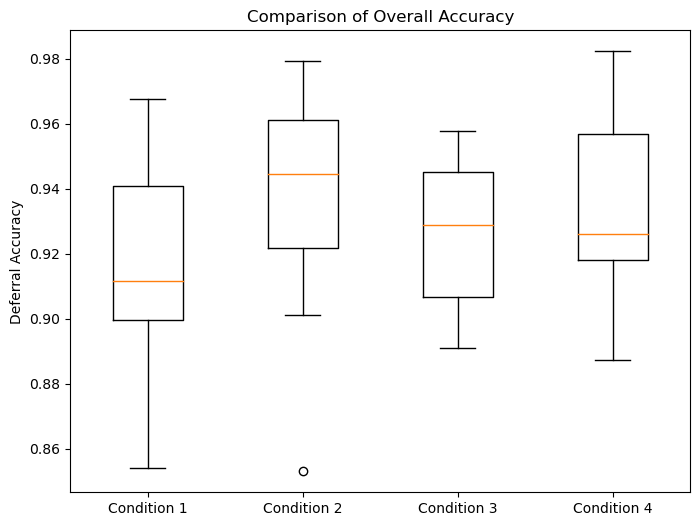

In [70]:
# Combine dataframes into a single list for plotting
data = [df_base["ACC_TEST"], df_cond2["deferral_acc"], df_cond3["overall_accuracy"], df_cond4["overall_accuracy"]]

# Labels for the boxplots
labels = ["Condition 1", "Condition 2", "Condition 3", "Condition 4"]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create vertical box and whisker plots
ax.boxplot(data, labels=labels)

# Add labels and title
ax.set_title("Comparison of Overall Accuracy")
ax.set_ylabel("Deferral Accuracy")

# Display the plot
plt.show()

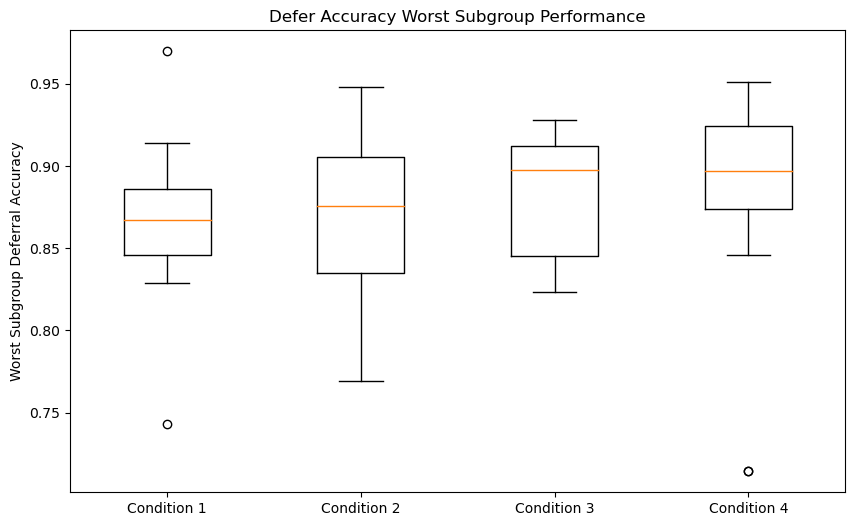

In [75]:
# Combine dataframes into a single list for plotting
df_base_worst = df_base[['race1_ACC_TEST', 'race2_ACC_TEST', 'race3_ACC_TEST']].min(axis=1)
df_cond2_worst = df_cond2[['black', 'other', 'white']].min(axis=1)
df_cond3_worst = df_cond3[['ACC_black', 'ACC_other', 'ACC_white']].min(axis=1)
df_cond4_worst = df_cond4[['ACC_black', 'ACC_other', 'ACC_white']].min(axis=1)

data = [df_base_worst, df_cond2_worst, df_cond3_worst, df_cond4_worst]

# Labels for the boxplots
labels = ["Condition 1", "Condition 2", "Condition 3", "Condition 4"]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create vertical box and whisker plots
ax.boxplot(data, labels=labels)

# Add labels and title
ax.set_title("Defer Accuracy Worst Subgroup Performance")
ax.set_ylabel("Worst Subgroup Deferral Accuracy")

# Display the plot
plt.show()

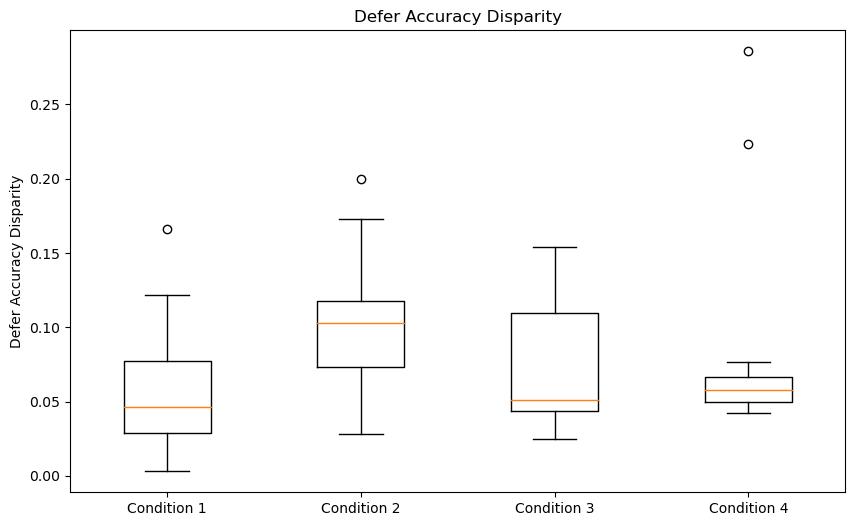

In [76]:
# Combine dataframes into a single list for plotting
df_base_disp = df_base[['race1_ACC_TEST', 'race2_ACC_TEST', 'race3_ACC_TEST']].max(axis=1) - df_base[['race1_ACC_TEST', 'race2_ACC_TEST', 'race3_ACC_TEST']].min(axis=1)
df_cond2_disp = df_cond2[['black', 'other', 'white']].max(axis=1) - df_cond2[['black', 'other', 'white']].min(axis=1)
df_cond3_disp = df_cond3[['ACC_black', 'ACC_other', 'ACC_white']].max(axis=1) - df_cond3[['ACC_black', 'ACC_other', 'ACC_white']].min(axis=1)
df_cond4_disp = df_cond4[['ACC_black', 'ACC_other', 'ACC_white']].max(axis=1) - df_cond4[['ACC_black', 'ACC_other', 'ACC_white']].min(axis=1)

data = [df_base_disp, df_cond2_disp, df_cond3_disp, df_cond4_disp]

# Labels for the boxplots
labels = ["Condition 1", "Condition 2", "Condition 3", "Condition 4"]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create vertical box and whisker plots
ax.boxplot(data, labels=labels)

# Add labels and title
ax.set_title("Defer Accuracy Disparity")
ax.set_ylabel("Defer Accuracy Disparity")

# Display the plot
plt.show()

In [79]:
df_cond4

,overall_accuracy,overall_auc,worst_accuracy,worst_ethnic_group,ACC_asian,ACC_black,ACC_other,ACC_white,AUC_asian,AUC_black,AUC_other,AUC_white,deferral_rate
test_hos,,,,,,,,,,,,,
73,0.982234,0.511480,0.951220,ACC_other,1.000000,1.000000,0.951220,0.983165,NaN,1.000000,NaN,0.027027,0.170051
167,0.905000,0.807660,0.887273,ACC_white,1.000000,0.925000,0.948718,0.887273,NaN,0.435897,0.906667,0.824176,0.245000
188,0.922500,0.772237,0.909408,ACC_white,1.000000,0.959184,0.916667,0.909408,NaN,0.979167,NaN,0.748451,0.170000
199,0.925000,0.876551,0.714286,ACC_other,NaN,1.000000,0.714286,0.926509,NaN,1.000000,0.833333,0.861508,0.192500
243,0.970000,0.782564,0.928571,ACC_other,1.000000,0.957143,0.928571,0.979424,NaN,0.777778,0.923077,0.708159,0.102500
252,0.887218,0.724419,0.883333,ACC_white,1.000000,0.925926,0.909091,0.883333,NaN,0.660000,1.000000,0.724394,0.250627
264,0.956410,0.766141,0.923077,ACC_black,1.000000,0.923077,1.000000,0.957746,NaN,0.854167,1.000000,0.749552,0.215385
300,0.947500,0.929610,0.904762,ACC_other,1.000000,0.913043,0.904762,0.954407,NaN,0.844961,0.962500,0.942633,0.170000
338,0.957393,0.783940,0.937500,ACC_other,1.000000,1.000000,0.937500,0.957447,NaN,NaN,0.820513,0.776500,0.187970
